In [ ]:
#instala o pacote imdb
!pip install -q imdb-sqlite

In [ ]:
#instala o pacote 
#https://pypi.org/project/pycountry/
!pip install -q pycountry

In [1]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

In [ ]:
##baixa o banco de dados do IMDB
## aguarde baixar tudo (maximo e aproximadamente 40min, dependendo da sua conexão e hardware)
%%time
!imdb-sqlite

In [2]:
##conectando a banco de dados
conn = sqlite3.connect("imdb.db")

In [ ]:
#extrai a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_name' FROM sqlite_master WHERE type='table'", conn)

In [ ]:
tabelas.head()

In [ ]:
#convertendo dataframe em lista
tabelas = tabelas["Table_name"].values.tolist()

In [ ]:
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta,conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Análise Exploratória de Dados

## 1 - Quais são as categorias de filmes mais comuns no imdb?
Quais são os principais tipos(categorias) dos titulos(filmes)?

In [ ]:
#Cria Consulta SQL
consulta1 = "SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type"

In [ ]:
#Extraindo o resultado
resultado1 = pd.read_sql_query(consulta1, conn)

In [ ]:
display(resultado1)

In [ ]:
#Percentual de cada tipo
resultado1["percentual"] = (resultado1["COUNT"] / resultado1["COUNT"].sum())*100

In [ ]:
display(resultado1)

In [ ]:
#apresentando o resultado em gŕafico
outros = {}


#filtra o percentual em 5% e soma o total
outros["COUNT"] = resultado1[resultado1["percentual"] < 5]["COUNT"].sum()

#Gravando o percentual
outros["percentual"] = resultado1[resultado1["percentual"] < 5]["percentual"].sum()

outros["type"] = "outros"


In [ ]:
outros

In [ ]:
#Filtra o dataframe/tabela de dados de resultados
resultado1 = resultado1[resultado1["percentual"]>5]

In [ ]:
#adiciona o dataframe de outras categorias e ignora o index
resultado1 = resultado1.append(outros, ignore_index =True)

In [ ]:
#ordena o resultado
resultado1 = resultado1.sort_values(by="COUNT", ascending=False)

In [ ]:
#visualiza
resultado1.head()

In [ ]:
#ajustando os labels usando listcomprehension
labels = [str(resultado1["type"][i])+ ' ' + '['+ str(round(resultado1["percentual"][i],2))+ '%' + ']' for i in resultado1.index]

In [ ]:
#Plot

#Mapa de Cores
#https://matplotlib.org/stablee/tutorials/color/colormaps.html
cs = cm.Set3(np.arange(100))
#cria a figura
f = plt.figure()
#Pie Plot
plt.pie(resultado1["COUNT"], labeldistance=1,radius=3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = "center", prop = {"size":12})
plt.title("Distribuição de Títulos", loc = "center", fontdict = {"fontsize":20, "fontweight":20})
plt.show()

## 2 - Qual o número de títulos por gênero? 

Calculando o número de filmes por gênero e entregar o resultado em valor percentual.

In [ ]:
#Criando a consulta SQL
consulta2 = "SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres"

In [ ]:
#Aplicando a query na conexão
resultado2 = pd.read_sql_query(consulta2,conn)

In [ ]:
display(resultado2)

In [ ]:
#padronizando os nomes dos gêneros colocando todos em minúsculo
resultado2['genres'] = resultado2['genres'].str.lower().values

In [ ]:
#descartando valores ausentes
temp = resultado2['genres'].dropna()

## Usando o Countvectorize para contar o número de filmes em cada gênero

In [ ]:
# Criando um vetor usando uma expressão regular para filtrar as strings
# https://docs.python.org/3.8/library/re.html
padrao = "(?u)\\b[\\w-]+\\b"

vetor = CountVectorizer(token_pattern=padrao, analyzer='word').fit(temp)

In [ ]:
type(vetor)

In [ ]:
#aplicando a vetorização ao dataset sem os valores ausentes/NA
bag_generos = vetor.transform(temp)

In [ ]:
type(bag_generos)

In [ ]:
# retornando os gêneros únicos
generos_uni = vetor.get_feature_names()

In [ ]:
generos = pd.DataFrame(bag_generos.todense(), columns = generos_uni, index = temp.index)

In [ ]:
generos.info()

In [ ]:
#removendo a coluna 18
generos = generos.drop(columns='n', axis=0)

In [ ]:
#calculando o percentual
gen_percent = 100 * pd.Series(generos.sum()).sort_values(ascending=False) / generos.shape[0]

In [ ]:
gen_percent.head(10)

In [ ]:
#Plot
# Mostrando os dados em gráfico
plt.figure(figsize = (16,8))
sns.barplot(x = gen_percent.values, y = gen_percent.index, orient="h", palette="terrain")
plt.ylabel("Gênero")
plt.xlabel("\nPercentual de Filmes(%)")
plt.title("\nNúmero(Percentual) de Títulos Por Gênero\n")
plt.show()

## Qual a mediana de avaliação dos filmes por gênero?
Mediana da avaliação dos filmess

In [ ]:
#Cunsulta SQL
consulta3 = '''
            SELECT rating, genres FROM ratings
            JOIN titles ON ratings.title_id = titles.title_id\
            WHERE premiered <= 2022 AND type = 'movie'
            '''

In [ ]:
#resultado
resultado3 = pd.read_sql_query(consulta3,conn)

In [ ]:
display(resultado3)

In [ ]:
#modularizando o código criando uma função para retornar os gêneros

def res_generos(df):
    df["genres"] = df["genres"].str.lower().values
    temp = df["genres"].dropna()
    vetor = CountVectorizer(token_pattern="(?u)\\b[\\w-]+\\b", analyzer="word").fit(temp)
    gen_uni = vetor.get_feature_names()
    gen_uni = [genre for genre in gen_uni if len(genre) > 1]
    return gen_uni

In [ ]:
gen_uni = res_generos(resultado3)

In [ ]:
gen_uni

In [ ]:
# lista filmes por gênero
genero_counts = []
#lista filmes por avaliação
genero_ratings = []

In [ ]:
#customizando as buscas 

for item in gen_uni:
    
    #retorna a contagem de filmes por gênero
    consulta = "SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE"+ "\""+"%"+item+"%"+"\" AND type=\'movie\'"
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
    
    #retorna a avaliação de filmes por gênero
    consulta = "SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE" + "\""+"%"+item+"%"+"\" AND type=\'movie\'"
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado["rating"]))

In [ ]:
#Preparando o dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings["genres"] = gen_uni
df_genero_ratings["count"] = genero_counts
df_genero_ratings["rating"] = genero_ratings

In [ ]:
df_genero_ratings.head(20)

In [ ]:
#drop item 18 (news)
df_genero_ratings = df_genero_ratings.drop(index=18)

In [ ]:
df_genero_ratings = df_genero_ratings.sort_values(by = "rating",ascending=False)

In [ ]:
#Plot

#figura
plt.figure(figsize=(16,20))

#Barplot

sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

#textos dos gráficos

for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0, i + 0.25, str(df_genero_ratings["count"][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]], i + 0.25, round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))


plt.xlabel("Gênero")
plt.ylabel("Avaliação")
plt.title("\nMediana de Avaliação por Gênero\n")
plt.show()

## Qual a mediana de avaliação dos filmes em relação ao ano de estreia?
mediana de avaliação dos filmes

In [ ]:
consulta4 = """
            SELECT rating AS Rating, premiered FROM ratings 
            JOIN titles ON ratings.title_id = titles.title_id
            WHERE premiered <= 2022 AND type='movie'
            ORDER BY premiered
            """

In [ ]:
resultado4 = pd.read_sql_query(consulta4, conn)

In [ ]:
display(resultado4)

In [ ]:
### mediana para cada ano
ratings = []
for ano in set(resultado4["premiered"]):
    ratings.append(np.median(resultado4[resultado4["premiered"] == ano]["Rating"]))

In [ ]:
type(ratings)

In [ ]:
ratings[1:10]

In [ ]:
anos = list(set(resultado4["premiered"]))

In [ ]:
anos[1:10]

In [ ]:
#Plot

plt.figure(figsize=(16,9))
plt.plot(anos, ratings)
plt.xlabel("\nAno")
plt.ylabel("Mediana de Avaliação")
plt.title("Mediana de Avaliação dos Filmes Em Relação ao Ano de Lançamento\n")
plt.show()

## Qual o número de filmes avaliados por gênero em relação ao ano de estreia?
Top 5 filmes avaliados pelo gênero

In [ ]:
consulta5 = "SELECT genres FROM titles"

In [ ]:
resultado5 = pd.read_sql_query(consulta5, conn)

In [ ]:
display(resultado5)

In [ ]:
generos_unicos = res_generos(resultado5)

In [ ]:
generos_unicos

In [ ]:
genero_count = []
for item in generos_unicos:
    consulta = "SELECT COUNT(*) COUNT FROM titles WHERE genres LIKE "+ "\""+"%"+item+"%"+"\"AND type=\'movie\' AND premiered <= 2022"
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado["COUNT"].values[0])

In [ ]:
#preparando o dataframe
df_genero_count = pd.DataFrame()
df_genero_count["genre"] = generos_unicos
df_genero_count["Count"] = genero_count

In [ ]:
#TOP 5
df_genero_count = df_genero_count[df_genero_count["genre"] != "n"]
df_genero_count = df_genero_count.sort_values(by="Count",ascending=False)
top_generos = df_genero_count.head()["genre"].values

In [ ]:
#plot
plt.figure(figsize=(16,8))

for item in top_generos:
    consulta = "SELECT COUNT(*) Number_of_movies, premiered Year FROM titles WHERE genres LIKE"+ "\""+"%"+item+"%"+"\"AND type=\'movie\' AND premiered <= 2022"
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado["Year"], resultado["Number_of_movies"])


plt.xlabel("\nAno")
plt.ylabel("Número de Filmes Avaliados")
plt.title("\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n")
plt.legend(labels=top_generos)
plt.show()

## Qual o filme com maior tempo de duração. Calcular os percentis

In [ ]:
consulta6 = """
            SELECT runtime_minutes Runtime
            FROM titles
            WHERE type="movie" AND Runtime != "NaN"
            """

In [ ]:
resultado6 = pd.read_sql_query(consulta6, conn)

In [ ]:
display(resultado6)

In [ ]:
for i in range(101):
    perc = round(np.percentile(resultado6["Runtime"].values, i),2)
    print("{} percentil da duração (runtime) é: {}".format(i,perc))

In [ ]:
consulta6 = """
            SELECT runtime_minutes Runtime, primary_title
            FROM titles
            WHERE type="movie" AND Runtime != "NaN"
            ORDER BY Runtime DESC
            LIMIT 1
            """

In [ ]:
resultado6 = pd.read_sql_query(consulta6, conn)

In [ ]:
display(resultado6)

* Logistics é o filme mais longo já feito.

## Qual a relação dos filmes entre duração e gênero?

In [ ]:
consulta7 = """
            SELECT AVG(runtime_minutes) Runtime, genres
            FROM titles
            WHERE type="movie"
            AND runtime_minutes != "NaN"
            GROUP BY genres
            """

In [ ]:
resultado7 = pd.read_sql_query(consulta7, conn)

In [ ]:
generos_unicos = res_generos(resultado7)

In [ ]:
genero_runtime = []

for item in generos_unicos:
    consulta = "SELECT runtime_minutes Runtime FROM titles WHERE genres LIKE"+ "\""+"%"+item+"%"+"\" AND type=\"movie\" AND Runtime !=\"NaN\""
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado["Runtime"]))

In [ ]:
df_genero_runtime = pd.DataFrame()
df_genero_runtime["genres"] = generos_unicos
df_genero_runtime["runtime"] = genero_runtime

In [ ]:
df_genero_runtime = df_genero_runtime.drop(index=18)

In [ ]:
df_genero_runtime = df_genero_runtime.sort_values(by="runtime", ascending=False)

In [ ]:
plt.figure(figsize=(16,9))

sns.barplot(y=df_genero_runtime.genres, x=df_genero_runtime.runtime, orient="h")

for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]], i + 0.25, round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.xlabel("\nMediana de tempo de duração(minutos)")
plt.ylabel("Gênero")
plt.title("\nRelação entre duração e gênero\n")
plt.show()

## Qual o número de filmes produzidos por país?

In [3]:
consulta8 = """
            SELECT region, COUNT(*) Number_of_movies FROM
            akas JOIN titles ON
            akas.title_id = titles.title_id
            WHERE region != "None"
            AND type = \"movie\"
            GROUP BY region
            """

In [4]:
resultado8 = pd.read_sql_query(consulta8, conn)

In [5]:
display(resultado8)

,region,Number_of_movies
0,AD,22
1,AE,331
2,AF,108
3,AG,12
4,AL,1232
...,...,...
228,YUCS,146
229,ZA,3016
230,ZM,11
231,ZRCD,2


In [6]:
resultado8.shape

(233, 2)

In [7]:
#nº de linhas
resultado8.shape[0]

233

In [8]:
nome_paises = []
contagem = []

In [9]:
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8["region"].values[i]
        nome_paises.append(pycountry.countries.get(alpha_2=coun).name)
        contagem.append(resultado8["Number_of_movies"].values[i])
    except:
        continue

In [11]:
df_filmes_paises = pd.DataFrame()
df_filmes_paises["country"] = nome_paises
df_filmes_paises["Movie_Count"] = contagem

In [12]:
df_filmes_paises = df_filmes_paises.sort_values(by="Movie_Count", ascending=False)

In [13]:
df_filmes_paises.head(10)

,country,Movie_Count
199,United States,260967
65,United Kingdom,118319
96,Japan,88460
63,France,81461
89,India,72752
32,Canada,69100
47,Germany,65928
93,Italy,63354
26,Brazil,62220
58,Spain,62063


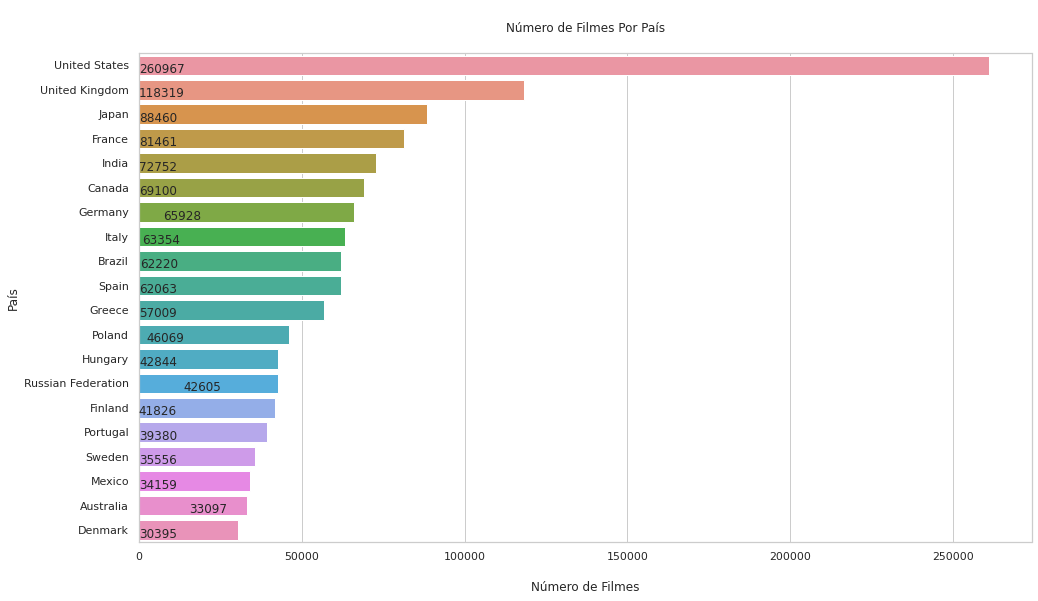

In [17]:
plt.figure(figsize=(16,9))

sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient="h")


for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]-1], i + 0.30,
            round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]], 2))

plt.xlabel("\nNúmero de Filmes")
plt.ylabel("País")
plt.title("\nNúmero de Filmes Por País\n")
plt.show()

## Top 10 Melhores Filmes

In [21]:
consulta9 = """
            SELECT primary_title AS Movie_Name, genres, rating
            FROM titles JOIN ratings
            ON titles.title_id = ratings.title_id
            WHERE titles.type = "movie" AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10
            """

In [22]:
#Resultado
top10_melhores = pd.read_sql_query(consulta9, conn)

In [23]:
display(top10_melhores)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,The Godfather,"Crime,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.2
4,Soorarai Pottru,Drama,9.1
5,12 Angry Men,"Crime,Drama",9.0
6,The Godfather: Part II,"Crime,Drama",9.0
7,The Dark Knight,"Action,Crime,Drama",9.0
8,David Attenborough: A Life on Our Planet,"Biography,Documentary",9.0
9,Schindler's List,"Biography,Drama,History",8.9


## Top 10 piores filmes

In [27]:
consulta10 ="""
            SELECT primary_title AS Movie_Name, genres, rating
            FROM titles JOIN ratings
            ON titles.title_id = ratings.title_id
            WHERE titles.type = "movie" AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10
            """

In [28]:
#Resultado
top10_piores = pd.read_sql_query(consulta10, conn)

In [29]:
display(top10_piores)

,Movie_Name,genres,rating
0,Cumali Ceber,Comedy,1.0
1,Smolensk,"Drama,Thriller",1.1
2,Sadak 2,"Action,Drama",1.1
3,Reis,"Biography,Drama",1.4
4,Justin Bieber: Never Say Never,"Documentary,Music",1.6
5,Manos: The Hands of Fate,"Drama,Horror",1.8
6,Radhe,"Action,Crime,Thriller",1.8
7,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
8,The Hottie & the Nottie,"Comedy,Romance",1.9
9,Disaster Movie,"Comedy,Sci-Fi",1.9


## FIM
